First we import tensorflow, numpy and matplotlib.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

The next cell defines a function to load in the MNIST csv files I downloaded and zipped (you gotta unzip them yourself), and then loads the data. This takes a minute because the method I am using to load data is slow.

In [ ]:
def load(f):
    F = open(f,"r")
    out = []
    label = []
    for l in F:
        temp = [int(t) for t in l.split(",")]
        out.append(temp[1:])
        label.append(temp[0])
        
    return np.array(out),np.array(label)

train_data,train_label = load("./mnist_train.csv")
test_data,test_label = load("./mnist_test.csv")

Visualize a digit, becasue it's always good to look at your data!

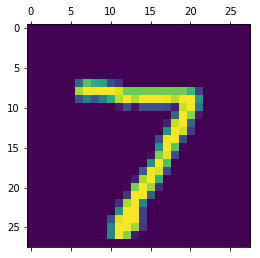

In [3]:
plt.matshow(np.reshape(test_data[0],[28,28]))
plt.show()

Set hyperparameters

In [10]:
batch_size = 16
data_size = len(test_data[0])
learning_rate = .001
n_epochs = 5000
n_labels = 10

Normalize the data. Note that we retain `m` and `s` so that we can normalize the test data in exactly the same way!

In [7]:
m = np.mean(train_data)
s = np.std(train_data)

normed_data = (train_data - m)/s

These placeholders represent the inputs and labels for the data, which we will fill in later.

In [8]:
input_data = tf.placeholder(tf.float32,shape = (None,data_size))
labels = tf.placeholder(tf.float32,shape = (None,10))

This defines the neural network layer by layer. Note that the last layer uses a linear activation function to generate *unnormalized log probabilities*. This is beause the loss function I used assumes the inputs are as such, and applies a softmax internally.

In [11]:
layer1 = tf.layers.dense(input_data,256,activation = tf.nn.relu)
layer2 = tf.layers.dense(layer1,256,activation = tf.nn.relu)
layer3 = tf.layers.dense(layer2,256,activation = tf.nn.relu)

logits = tf.layers.dense(layer2,n_labels,activation = None)

Define the loss: average cross entropy loss between the NN output and the 1-hot encoded labels. Also create an ADAM optimizer and generate the training operation `train`.

In [13]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = labels, logits = logits))
adam = tf.train.AdamOptimizer(learning_rate = learning_rate)

train = adam.minimize(loss)

These helper functions take in a set of labels and generates a 1-hot encoding of them (`make_1hot`) and calculate the error based on the MAP estimate of the label (`MNIST_err`).

In [14]:
def make_1hot(l):
    out = np.zeros(shape = (len(l),n_labels))
    for k in range(len(l)):
        out[k][l[k]] = 1
        
    return out

def MNIST_err(l,p):
    out = []
    for k in range(len(l)):
        if l[k][np.argmax(p[k])] == 1:
            out.append(1)
        else:
            out.append(0)
            
    return np.mean(out)

Create a session (on CPU) and initialize all the TF variables. That is, the weights and biases of the network, and the adam momentum variables. 

In [20]:
init = tf.global_variables_initializer()
config = tf.ConfigProto(device_count = {'GPU': 0})
sess = tf.Session(config=config)
sess.run(init)

Run the training loop! 

At each step, pick a random batch of training data, run the training operation substituting in the batch of data for the placeholders above. 

Also periodically run the test data and record the train and test data.

In [21]:
results = []
print_freq = 500
test_freq = 10
normed_test = (test_data - m)/s
test_label_1h = make_1hot(test_label)

for k in range(n_epochs):
    b_index = np.random.choice(range(len(test_data)),batch_size,replace = False)
    batch_data = normed_data[b_index]
    batch_labels = make_1hot(train_label[b_index])
    
    _,train_loss,train_logits = sess.run([train,loss,logits],{input_data:batch_data,labels:batch_labels})
    
    if k%test_freq == 0:
        test_loss,test_logits = sess.run([loss,logits],{input_data:normed_test,labels:test_label_1h})
        results.append([k,MNIST_err(test_label_1h,test_logits),MNIST_err(batch_labels,train_logits)])
    if k%print_freq == 0:
        print("{}\t{}\t{}".format(k,train_loss,test_loss))
        
results = np.array(results)

0	1.9151102304458618	2.5552456378936768
500	0.05729486793279648	0.24501825869083405
1000	0.2852420508861542	0.231497660279274
1500	0.013165416195988655	0.2603171765804291
2000	0.0825764387845993	0.24509643018245697
2500	0.004385109059512615	0.24173368513584137
3000	0.3065479099750519	0.19611237943172455
3500	0.011401206254959106	0.19306066632270813
4000	0.005794445984065533	0.24705246090888977
4500	0.00010503707017051056	0.18752795457839966


In [22]:
sess.close()

Finally, visualize the results of training.

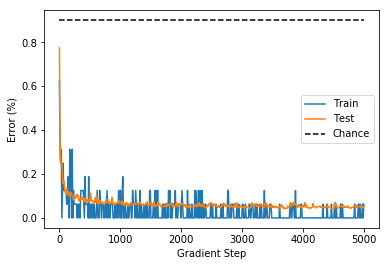

In [23]:
plt.plot(results[:,0],1-results[:,2],label = "Train")
plt.plot(results[:,0],1-results[:,1],label = "Test")
plt.plot(results[:,0],np.ones_like(results[:,1])*.9,"k--",label = "Chance")
plt.legend()
plt.xlabel("Gradient Step")
plt.ylabel("Error (%)")
#plt.xscale("log")
plt.show()

Things for YOU to play with:

    - Adjust learning rate, number/size of hidden layers, loss function (what about rms error?)
    - Add drop out between dense layers
    - Augment the dataset: flip horizontally/vertically. Affine transformations. Add Noise.
    - Try other activation functions
    - Try making the network convolutional